In [1]:
!pip install numpy matplotlib tqdm tensorflow pillow scikit-learn

In [2]:
import os, glob, numpy as np, keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from PIL import Image

from IPython import display 
from math import ceil

In [3]:
# Import necessary libraries
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.transforms import Bbox
import numpy as np
from keras.callbacks import Callback


In [5]:
import smtplib, sys, email, base64
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from email.mime.application import MIMEApplication

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator as KerasImageDataGenerator

from keras.layers import MaxPooling2D, Convolution2D, Input, Dense, Flatten
from keras.models import Model

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [7]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"    
# os.environ["CUDA_VISIBLE_DEVICES"]= "0"  # run GPU 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"  # run GPU 0,1
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"   # don't run GPU
os.environ['KERAS_BACKEND'] = "tensorflow"

## 2.2. Util Functions

In [8]:
def save_figure(fig, save_path):
    if save_path != None:
        (dir, file) = os.path.split(save_path)
        if os.path.exists(dir) == False:
            os.makedirs(dir)

        # If we haven't already shown or saved the plot, then we need to
        # draw the figure first...
        fig.canvas.draw()

        # Now we can save it to a numpy array.
        # data = np.fromstring(plt.gcf().canvas.tostring_rgb(), dtype=np.uint8, sep='')
        # data = data.reshape(plt.gcf().canvas.get_width_height()[::-1] + (3,))

        # plt.gcf().savefig(save_path)
        # Save just the portion _inside_ the second axis's boundaries
        # extent = plt.gca().get_tightbbox(plt.gcf().canvas.renderer).transformed(plt.gcf().dpi_scale_trans.inverted())
        fig.savefig(save_path)
# def save_figure

def plot_images(images, labels, decode_labels = None, title = '', 
                rows = 8, cols = 4, save_path = None, is_path = False, data_dir = ""):
    # idx = sorted(range(len(label_batch)), key=lambda k: decode_output(label_batch[k]))
    plt.figure(figsize=(16, 8))
    if is_path == True:
        images = [np.array(Image.open(os.path.join(data_dir, images[i]))) 
                  for i in range(len(images))]
    for row in range(rows):
        for col in range(cols):
            plt.subplot(rows, cols,row * cols + col + 1)
            plt.axis('off')
            if decode_labels is not None:
                plt.title('%s'%(decode_labels[int(labels[row * cols + col])]))
            else:
                plt.title('%s'%(labels[row * cols + col]))
            if len(images[row * cols + col].shape) == 2 or images[row * cols + col].shape[2] == 1:
                plt.imshow(images[row * cols + col][:,:,0], cmap = 'gray')
            else:
                plt.imshow(images[row * cols + col])
    plt.suptitle(title)
    save_figure(plt.gcf(), save_path)
    plt.show()
    plt.close()
    
def plotHist(labels, title='Codewords Dictionary'):
    dictionary = {}
    labels.sort()
    for labeli in labels:
        if dictionary.get(labeli)==None:
            dictionary[labeli] = 1
        else:
            dictionary[labeli] += 1
    names  = list(dictionary.keys())
    names.sort()
    values = [dictionary[key] for key in names]
    ranges = np.arange(len(names))
    plt.title(title)
    plt.bar(ranges, values, tick_label =names) 

## 2.3. Built-in Model Functions


In [9]:
def model_summary_string(model):
    try:
        from StringIO import StringIO
    except ImportError:
        from io import StringIO
    import sys

    # keep track of the original sys.stdout
    origStdout = sys.stdout

    # replace sys.stdout temporarily with our own buffer
    outputBuf  = StringIO()
    sys.stdout = outputBuf

    # print the model summary
    model.summary()

    # put back the original stdout
    sys.stdout = origStdout

    # get the model summary as a string
    modelDescription = outputBuf.getvalue()
    return modelDescription

def SMALL_CNN(classes, input_shape, weights_path = None):
    
    # Input Layer
    input = Input(shape = input_shape, name='input')
    
    # Block 1
    x = Convolution2D(64, (3, 3), activation='relu', name='conv1_1', padding = 'same')(input)
    x = Convolution2D(64, (3, 3), activation='relu', name='conv1_2', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool1')(x)
    x = Dropout(0.2)(x)
    
    # Block 2
    x = Convolution2D(128, (3, 3), activation='relu', name='conv2_1', padding = 'same')(x)
    x = Convolution2D(128, (3, 3), activation='relu', name='conv2_2', padding = 'same')(x)
    x = Convolution2D(256, (3, 3), activation='relu', name='conv3_1', padding = 'same')(x)
    x = Convolution2D(256, (3, 3), activation='relu', name='conv3_2', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool2')(x)
    x = Dropout(0.2)(x)
    
    
    # Classifier
    x = Flatten(name = 'flatten_1')(x)
    x = Dense(1024, activation='relu', name='dense_1')(x)
    x = Dropout(0.5)(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)
    
    model = Model(inputs=input, outputs=x)
    
    if weights_path is not None:
        model.load_weights(weights_path)
    
    return model

def MEDIUM_CNN(classes, input_shape, weights_path = None):
    
    # Input Layer
    input = Input(shape = input_shape, name='input')
    
    # Block 1
    x = Convolution2D(64, (3, 3), activation='relu', name='conv1_1', padding = 'same')(input)
    x = Convolution2D(64, (3, 3), activation='relu', name='conv1_2', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool1')(x)
    x = Dropout(0.2)(x)
    
    # Block 2
    x = Convolution2D(128, (3, 3), activation='relu', name='conv2_1', padding = 'same')(x)
    x = Convolution2D(128, (3, 3), activation='relu', name='conv2_2', padding = 'same')(x)
    x = Convolution2D(128, (3, 3), activation='relu', name='conv2_3', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool2')(x)
    x = Dropout(0.2)(x)
    
    # Block 3
    x = Convolution2D(256, (3, 3), activation='relu', name='conv3_1', padding = 'same')(x)
    x = Convolution2D(256, (3, 3), activation='relu', name='conv3_2', padding = 'same')(x)
    x = Convolution2D(256, (3, 3), activation='relu', name='conv3_3', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool3')(x)
    x = Dropout(0.2)(x)
    
    
    # Classifier
    x = Flatten(name = 'flatten_1')(x)
    x = Dense(1024, activation='relu', name='dense_1')(x)
    x = Dropout(0.5)(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)
    
    model = Model(inputs=input, outputs=x)
    
    if weights_path is not None:
        model.load_weights(weights_path)
    
    return model

def MEDIUM1_CNN(classes, input_shape, weights_path = None):
    
    # Input Layer
    input = Input(shape = input_shape, name='input')
    
    # Block 1
    x = Convolution2D(64, (3, 3), activation='relu', name='conv1_1', padding = 'same')(input)
    x = Convolution2D(64, (3, 3), activation='relu', name='conv1_2', padding = 'same')(x)
    x = Convolution2D(64, (3, 3), activation='relu', name='conv1_3', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool1')(x)
    x = Dropout(0.2)(x)
    
    # Block 2
    x = Convolution2D(128, (3, 3), activation='relu', name='conv2_1', padding = 'same')(x)
    x = Convolution2D(128, (3, 3), activation='relu', name='conv2_2', padding = 'same')(x)
    x = Convolution2D(128, (3, 3), activation='relu', name='conv2_3', padding = 'same')(x)
    x = Convolution2D(128, (3, 3), activation='relu', name='conv2_4', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool2')(x)
    x = Dropout(0.2)(x)
    
    # Block 3
    x = Convolution2D(256, (3, 3), activation='relu', name='conv3_1', padding = 'same')(x)
    x = Convolution2D(256, (3, 3), activation='relu', name='conv3_2', padding = 'same')(x)
    x = Convolution2D(256, (3, 3), activation='relu', name='conv3_3', padding = 'same')(x)
    x = Convolution2D(256, (3, 3), activation='relu', name='conv3_4', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool3')(x)
    x = Dropout(0.2)(x)
    
    
    # Classifier
    x = Flatten(name = 'flatten_1')(x)
    x = Dense(1024, activation='relu', name='dense_1')(x)
    x = Dropout(0.5)(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)
    
    model = Model(inputs=input, outputs=x)
    
    if weights_path is not None:
        model.load_weights(weights_path)
    
    return model
  
def LARGE_CNN(classes, input_shape, weights_path = None):
    
    # Input Layer
    input = Input(shape = input_shape, name='input')
    
    # Block 1
    x = Convolution2D(64, (3, 3), activation='relu', name='conv1_1', padding = 'same')(input)
    x = Convolution2D(64, (3, 3), activation='relu', name='conv1_2', padding = 'same')(x)
    x = Convolution2D(64, (3, 3), activation='relu', name='conv1_3', padding = 'same')(x)
    x = Convolution2D(64, (3, 3), activation='relu', name='conv1_4', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool1')(x)
    x = Dropout(0.2)(x)
    
    # Block 2
    x = Convolution2D(128, (3, 3), activation='relu', name='conv2_1', padding = 'same')(x)
    x = Convolution2D(128, (3, 3), activation='relu', name='conv2_2', padding = 'same')(x)
    x = Convolution2D(128, (3, 3), activation='relu', name='conv2_3', padding = 'same')(x)
    x = Convolution2D(128, (3, 3), activation='relu', name='conv2_4', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool2')(x)
    x = Dropout(0.2)(x)
    
    # Block 3
    x = Convolution2D(256, (3, 3), activation='relu', name='conv3_1', padding = 'same')(x)
    x = Convolution2D(256, (3, 3), activation='relu', name='conv3_2', padding = 'same')(x)
    x = Convolution2D(256, (3, 3), activation='relu', name='conv3_3', padding = 'same')(x)
    x = Convolution2D(256, (3, 3), activation='relu', name='conv3_4', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool3')(x)
    x = Dropout(0.2)(x)
    
    # Block 4
    x = Convolution2D(512, (3, 3), activation='relu', name='conv4_1', padding = 'same')(x)
    x = Convolution2D(512, (3, 3), activation='relu', name='conv4_2', padding = 'same')(x)
    x = Convolution2D(512, (3, 3), activation='relu', name='conv4_3', padding = 'same')(x)
    x = Convolution2D(512, (3, 3), activation='relu', name='conv4_4', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool4')(x)
    x = Dropout(0.2)(x)
    
    
    # Classifier
    x = Flatten(name = 'flatten_1')(x)
    x = Dense(2048, activation='relu', name='dense_1')(x)
    x = Dropout(0.5)(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)
    
    model = Model(inputs=input, outputs=x)
    
    if weights_path is not None:
        model.load_weights(weights_path)
    
    return model
  
# model = LARGE_CNN(7, (48, 48, 1), weights_path = None) 
# model.summary()

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from keras.callbacks import Callback

def plotHistory(epoch, acc, val_acc, xlabel='epoch', ylabel='accuracy', title='Model Accuracy', is_show=True):
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    # Debug: Print lengths of the lists
    print(f"Length of epoch: {len(epoch)}")
    print(f"Length of acc: {len(acc)}")
    print(f"Length of val_acc: {len(val_acc)}")

    # Check if the lengths of the lists are the same
    if len(epoch) == len(acc) == len(val_acc):
        # summarize history for accuracy
        plt.plot(epoch, acc)
        plt.plot(epoch, val_acc)
        plt.title(title)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.legend(['train', 'test'], loc='upper left')
    else:
        print("Error: Lengths of epoch, acc, and val_acc do not match.")

class HistogramCallback(Callback):
    def __init__(self, save_path=None, epochs=None, histories=None, save_name="histogram_model_{epoch:02d}.png"):
        super(HistogramCallback, self).__init__()
        self.epoch = epochs or []
        self.history = histories or {'acc': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}
        self.save_path = save_path
        self.save_name = save_name

    def show_history(self, epoch, update=True, name='history'):
        plt.figure(figsize=(12, 6))
        ax = plt.subplot(1, 2, 1), plotHistory(self.epoch, self.history['acc'], self.history['val_accuracy'], 
                                               ylabel='accuracy', title='Model Accuracy', is_show=False)
        plt.subplot(1, 2, 2), plotHistory(self.epoch, self.history['loss'], self.history['val_loss'], 
                                          ylabel='loss', title='Model Loss', is_show=False)
        plt.suptitle('Training at Epoch %d' % (epoch))

        if self.save_path is not None:
            save_path = os.path.join(self.save_path, self.save_name.format_map({"epoch": epoch}))
            save_figure(plt.gcf(), save_path)

        if update == False:
            display.display(plt.gcf(), display_id=name, update=update)
        else:
            display.update_display(plt.gcf(), display_id=name)
        plt.close()

    def on_epoch_begin(self, epoch, logs=None):
        self.show_history(epoch=epoch, update=True)
        pass

    def on_epoch_end(self, epoch, logs=None):
        if self.save_path:
            for layer in self.model.layers:
                if hasattr(layer, 'weights'):
                    for weight in layer.weights:
                        weight_values = weight.numpy().flatten()
                        plt.figure()
                        plt.hist(weight_values, bins=50)
                        plt.title(f'{layer.name} - {weight.name}')
                        plt.xlabel('Weight value')
                        plt.ylabel('Frequency')
                        file_path = os.path.join(self.save_path, f'{layer.name}_{weight.name}_epoch_{epoch}.png')
                        plt.savefig(file_path)
                        plt.close()



## 2.6. Others

In [11]:
import re, shutil, csv
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=True,
                          title='Average accuracy \n',
                          cmap=plt.cm.Blues, verbose = 0, precision = 0):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    
    cm  = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100.0
        if verbose == 1:
            print("Normalized confusion matrix")
    else:
        if verbose == 1:
            print('Confusion matrix, without normalization')
    
    if verbose == 1:
        print(cm)

    plt.figure(figsize=(18, 9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = '{:.'+ '%d'%(precision) +'f} %' if normalize else '{:d}'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, fmt.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=16)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    
def show_history(history, save_path = None):
    save_path = None

    epoch   = max(history["epoch"])
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(1,2,1), plotHistory(history['epoch'], history['accuracy'], history['val_accuracy'], 
                                                 ylabel = 'accuracy', title='Model Accuracy', is_show = False)
    plt.subplot(1,2,2), plotHistory(history['epoch'], history['loss'], history['val_loss'], 
                                            ylabel = 'loss', title='Model Loss', is_show = False)
    plt.suptitle('Training at Epoch %d'%(epoch))

    if save_path != None:
        save_figure(plt.gcf(), save_path)
    plt.show()
    plt.close()
    
def convert_history_dict(array_hist):
    final_log_history = array_hist
    sort_history(array_hist, keys=['epoch'])
    history    = None
    headers    = None
    if len(array_hist)>0:
        if headers is None:
            headers = final_log_history[0].keys()
        history = {}
        for key in headers:
            history[key] = []
        for i in range(len(array_hist)):
            log = array_hist[i]
            for key in headers:
                if log.get(key) is not None:
                    if key == 'epoch':
                        history[key].append(int(log[key]))
                    else:
                        history[key].append(log[key])
                else:
                    history[key].append(0)
      # if    
    # if    
    return history

def read_weight_file(weights_dir, file_pattern = '*.h5', log_pattern = r'epoch-(?P<epoch>[\d.]+)\S*val_loss-(?P<val_loss>[\d.]+)\S*val_accuracy-(?P<val_accuracy>[\d.]+)\S*.h5'):
    pattern_re   = re.compile(log_pattern)

    results = glob.glob(os.path.join(weights_dir, file_pattern))
    history = []
    for result in results:
      ret = pattern_re.search(result)
      log = ret.groupdict() or {'epoch': 0, 'val_accuracy': 0.0, 'val_loss': 0.0, 'file': ''}
      for item in log.keys():
        log[item] = float(log[item])
      log['file'] = result
      history.append(log)
    return history

def read_history_file(histogram_dir, file_pattern = '*.png', log_pattern  = r'histogram_model_(?P<epoch>[\d]+)\S*.\S*'):
    pattern_re   = re.compile(log_pattern)
    results = glob.glob(os.path.join(histogram_dir, file_pattern))
    history = []
    for result in results:
        ret = pattern_re.search(result)
        log = ret.groupdict() or {'epoch': -1.0}
        for item in log.keys():
            log[item] = float(log[item])
        log['file'] = result
        history.append(log)
    return history

def read_log_file(log_file):
    history = []
    with open(log_file, 'rt') as csvfile:
        log_reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        header = next(log_reader)
        for row in log_reader:
            log = { }
            for col in range(len(header)):
                log[header[col]] = float(row[col])
            history.append(log)
    return history

def sort_history(history, keys = ['val_loss', 'val_accuracy', 'epoch'], orders={'epoch': 1, 'val_accuracy': -1, 'val_loss': 1}):
    def cmp_log(log):
        cur_key  = [(log[k]*orders[k]) for k in keys if log.get(k) is not None]
        return cur_key
    history.sort(key = cmp_log)
    
def write_history(history, filepath, headers = None):
    if len(history) > 0: 

        if headers == None:
            headers = list(history[0].keys())

        with open(filepath, 'wt') as csvfile:
            log_writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
            log_writer.writerow(headers)

            for i in range(len(history)):
                row = []
                for j in range(len(headers)):
                    key = headers[j]
                    if history[i].get(key) is not None:
                        if key == 'epoch':
                            row.append(int(history[i][key]))
                        else:
                            row.append(history[i][key])
                    else:
                        row.append('')
                # for
                log_writer.writerow(row)
            # for
        # with
    # if
# def write_history

def backup_after_train(csv_log_path, weights_dir, histogram_dir):
    hist_history   = read_history_file(histogram_dir)
    log_history    = read_log_file(csv_log_path)
    weight_history = read_weight_file(weights_dir)

    sort_history(log_history)
    sort_history(weight_history)

    top = 2
    epoch_max = -1
    epochs = []
    for i in range(len(log_history)):
        epoch = int(log_history[i]['epoch'])
        if (top>=1) and ((epoch_max == -1) or (epoch_max>epoch)):
            epoch_max = epoch
            top -= 1
            epochs.append(epoch_max)

    if len(epochs)>0:
        min = epochs[-1]
        max = epochs[0]

        final_weight_history = []
        for i in range(len(weight_history)):
            epoch = int(weight_history[i]['epoch']) - 1
            file  = weight_history[i]['file']
            if epoch>max or epoch<min:
                os.remove(file)
            else:
                final_weight_history.append(weight_history[i])

        final_hist_history = []
        for i in range(len(hist_history)):
            epoch = int(hist_history[i]['epoch'])
            file  = hist_history[i]['file']
            if epoch>max or epoch<min:
                os.remove(file)
            else:
                final_hist_history.append(hist_history[i])

        final_log_history = []
        for i in range(len(log_history)):
            epoch = int(log_history[i]['epoch'])
            if epoch>max:
                pass
            else:
                final_log_history.append(log_history[i])

        pass
    sort_history(final_log_history, keys = ['epoch'], orders={'epoch': 1})
    sort_history(final_weight_history, keys = ['epoch'], orders={'epoch': 1})
    sort_history(final_hist_history, keys = ['epoch'], orders={'epoch': 1})
    
    (name, ext) = os.path.splitext(csv_log_path)
    results = glob.glob(name + '_bak*' + ext)
    if len(results)>0:
        shutil.copyfile(csv_log_path, name + '_bak' + '({})'.format(len(results)) + ext)    
    else:
        shutil.copyfile(csv_log_path, name + '_bak' + ext)
    write_history(final_log_history, csv_log_path)
    
    return (final_log_history, final_weight_history, final_hist_history)

# 3.Dataset Processing


## 3.1. Extract Dataset

In [12]:
kaggle_challenge_zip_file = 'archive.zip'
kaggle_challenge_extract_dir = 'dataset'
dataset_dir   = 'dataset/fer2013'


In [13]:
import os
import pandas as pd
import numpy as np
from PIL import Image

# Đường dẫn đến tệp CSV và thư mục đầu ra
input_path = '/kaggle/input/facialexpressionrecognition/fer2013.csv'
output_dir = '/kaggle/working/dataset'

# Tạo các thư mục đầu ra
os.makedirs(output_dir, exist_ok=True)
for subset in ['Training', 'PublicTest', 'PrivateTest']:
    for emotion in ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']:
        os.makedirs(os.path.join(output_dir, subset, emotion), exist_ok=True)

# Đọc tệp CSV
df = pd.read_csv(input_path)

# Tạo từ điển ánh xạ từ số nhãn cảm xúc sang tên thư mục
emotion_map = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

# Duyệt qua từng hàng trong DataFrame và lưu hình ảnh vào thư mục tương ứng
for index, row in df.iterrows():
    emotion = emotion_map[row['emotion']]
    subset = row['Usage']
    pixels = np.array(row['pixels'].split(), dtype=np.uint8).reshape(48, 48)
    img = Image.fromarray(pixels)
    
    # Đường dẫn lưu hình ảnh
    img_path = os.path.join(output_dir, subset, emotion, f'{index}.png')
    
    # Lưu hình ảnh
    img.save(img_path)

print("Đã tạo thư mục đầu ra với các hình ảnh tương ứng.")


Đã tạo thư mục đầu ra với các hình ảnh tương ứng.


In [14]:
# Install necessary libraries
# Import necessary libraries
import os
import cv2
import numpy as np
import shutil
import tqdm
from IPython import display

# Define the function to extract the dataset
def extract_fer2013_dataset(input_path, output_path, is_forced=False, verbose=False):
    if (is_forced == False) and (os.path.exists(os.path.join(output_path, 'Training')) == True
                                 and os.path.exists(os.path.join(output_path, 'PrivateTest')) == True
                                 and os.path.exists(os.path.join(output_path, 'PublicTest')) == True):
        return

    if os.path.exists(output_path) == False:
        os.makedirs(output_path)
    label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    data = np.genfromtxt(input_path, delimiter=',', dtype=None, encoding=None)
  
    # Read data (col 0: labels, 1: image buffer, 2: usage)
    labels = data[1:, 0].astype(np.int32)
    image_buffer = data[1:, 1]
    images = np.array([np.fromstring(image, np.uint8, sep=' ') for image in image_buffer])
    usage = data[1:, 2]
    dataset = list(zip(labels, images, usage))
    display.display('Process: 0 / %d' % (len(dataset)), display_id='process')
    for i in range(len(dataset)):
        d = dataset[i]
        usage_path = os.path.join(output_path, d[-1])
        label_path = os.path.join(usage_path, label_names[d[0]])
        img = d[1].reshape((48, 48))
        img_name = 'img_%05d.png' % i
        img_path = os.path.join(label_path, img_name)
        if not os.path.exists(usage_path):
            os.makedirs(usage_path)
        if not os.path.exists(label_path):
            os.makedirs(label_path)
        cv2.imwrite(img_path, img)
        if verbose == True:
            print('Write %s' % (img_path))
        display.display('Process %d / %d: %s' % (i, len(dataset), img_path), display_id='process')
    # for
# extract_fer2013_dataset

# Set the correct paths for Kaggle environment
input_path = '/kaggle/input/facialexpressionrecognition/fer2013.csv'
output_path = '/kaggle/working/dataset'

# Extract the dataset
extract_fer2013_dataset(input_path, output_path, False)

# List the contents of the output directory
!ls $output_path

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


PrivateTest  PublicTest  Training


In [15]:
# Install necessary libraries
# Import necessary libraries
import os
import glob
import numpy as np
from PIL import Image

# Set the correct paths for Kaggle environment
dataset_dir = '/kaggle/working/dataset'

# Load training images
train_files = glob.glob(os.path.join(dataset_dir, 'Training/*', '*.png'))
train_labels = [os.path.basename(os.path.split(file)[0]) for file in train_files]
train_images = [np.array(Image.open(file)) for file in train_files]
if len(train_images) > 0 and len(train_images[0].shape) == 2:
    train_images = [train_images[i].reshape(train_images[i].shape[0], train_images[i].shape[1], 1) for i in range(len(train_images))]

# Load public test images
public_files = glob.glob(os.path.join(dataset_dir, 'PublicTest/*', '*.png'))
public_labels = [os.path.basename(os.path.split(file)[0]) for file in public_files]
public_images = [np.array(Image.open(file)) for file in public_files]
if len(public_images) > 0 and len(public_images[0].shape) == 2:
    public_images = [public_images[i].reshape(public_images[i].shape[0], public_images[i].shape[1], 1) for i in range(len(public_images))]

# Load private test images
private_files = glob.glob(os.path.join(dataset_dir, 'PrivateTest/*', '*.png'))
private_labels = [os.path.basename(os.path.split(file)[0]) for file in private_files]
private_images = [np.array(Image.open(file)) for file in private_files]
if len(private_images) > 0 and len(private_images[0].shape) == 2:
    private_images = [private_images[i].reshape(private_images[i].shape[0], private_images[i].shape[1], 1) for i in range(len(private_images))]

# Print the number of images loaded for each set
print(f"Number of training images: {len(train_images)}")
print(f"Number of public test images: {len(public_images)}")
print(f"Number of private test images: {len(private_images)}")

Number of training images: 28709
Number of public test images: 3589
Number of private test images: 3589


## 3.4. Normalize dataset


In [16]:
# Label encoder

classes_file = os.path.join(dataset_dir, 'classes.npy')
label_encoder = LabelEncoder()
if not os.path.exists(classes_file):
    label_encoder.fit(np.hstack([train_labels, public_labels, private_labels]))
    np.save(classes_file, label_encoder.classes_)
    classes = label_encoder.classes_
else:
    label_encoder.classes_ = np.load(classes_file)
    classes = label_encoder.classes_

# Print the classes to verify
print(f"Classes: {classes}")

Classes: ['Angry' 'Disgust' 'Fear' 'Happy' 'Neutral' 'Sad' 'Surprise']


In [17]:
train_encoded_labels = label_encoder.transform(train_labels)
train_onehot_encoded_labels = keras.utils.to_categorical(train_encoded_labels)

public_encoded_labels = label_encoder.transform(public_labels)
public_onehot_encoded_labels = keras.utils.to_categorical(public_encoded_labels)

private_encoded_labels = label_encoder.transform(private_labels)
private_onehot_encoded_labels = keras.utils.to_categorical(private_encoded_labels)

x_train = np.array(train_images)
y_train = np.array(train_onehot_encoded_labels)

x_valid = np.array(public_images)
y_valid = np.array(public_onehot_encoded_labels)

x_test  = np.array(private_images)
y_test = np.array(private_onehot_encoded_labels)

print('Training: ', len(x_train), 'Public: ', len(x_valid), 'Private: ', len(x_test))

Training:  28709 Public:  3589 Private:  3589


In [18]:
print('Debug Decoder')
def decode_output(output, classes):
    return classes[(np.argmax(output))]
# def decode_output
print(classes)
print(private_onehot_encoded_labels[1000], decode_output(private_onehot_encoded_labels[1000], classes))

Debug Decoder
['Angry' 'Disgust' 'Fear' 'Happy' 'Neutral' 'Sad' 'Surprise']
[0. 0. 0. 0. 0. 1. 0.] Sad


In [19]:
# Checking
idx = 18500
print('Classes: ', label_encoder.classes_)
print('\ny_train:', y_train[idx])
print('y_train_onehot_encoded_labelstrain:', train_onehot_encoded_labels[idx])
print('train_labels:', train_labels[idx])
print('train_files:', train_files[idx])

idx = 1500
print('\ny_valid:', y_valid[idx])
print('public_onehot_encoded_labels:', public_onehot_encoded_labels[idx])
print('public_labels:', public_labels[idx])
print('public_files:', public_files[idx])

idx = 1500
print('\ny_test:', y_test[idx])
print('private_onehot_encoded_labels:', private_onehot_encoded_labels[idx])
print('private_labels:', private_labels[idx])
print('private_files:', private_files[idx])

Classes:  ['Angry' 'Disgust' 'Fear' 'Happy' 'Neutral' 'Sad' 'Surprise']

y_train: [0. 0. 0. 0. 0. 0. 1.]
y_train_onehot_encoded_labelstrain: [0. 0. 0. 0. 0. 0. 1.]
train_labels: Surprise
train_files: /kaggle/working/dataset/Training/Surprise/24705.png

y_valid: [0. 0. 0. 0. 1. 0. 0.]
public_onehot_encoded_labels: [0. 0. 0. 0. 1. 0. 0.]
public_labels: Neutral
public_files: /kaggle/working/dataset/PublicTest/Neutral/31275.png

y_test: [0. 0. 0. 0. 1. 0. 0.]
private_onehot_encoded_labels: [0. 0. 0. 0. 1. 0. 0.]
private_labels: Neutral
private_files: /kaggle/working/dataset/PrivateTest/Neutral/32609.png


## 3.5. Dataset Explorer

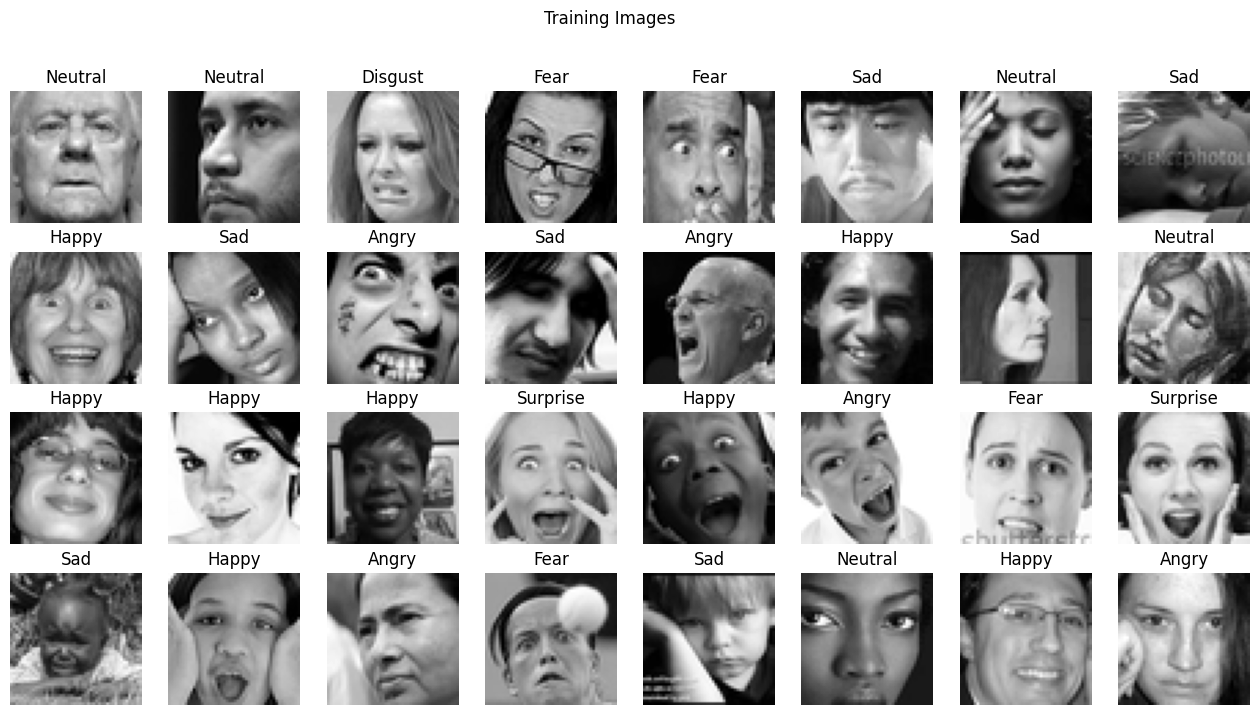

In [20]:
train_idx = np.random.randint(low=0, high=len(x_train), size=(32))
y_train_labels = [decode_output(output, classes) for output in y_train[train_idx]]
plot_images(x_train[train_idx], y_train_labels, title='Training Images', 
            decode_labels=None, rows=4, cols=8, is_path=False,
            save_path=os.path.join(dataset_dir, 'training_images.png'))

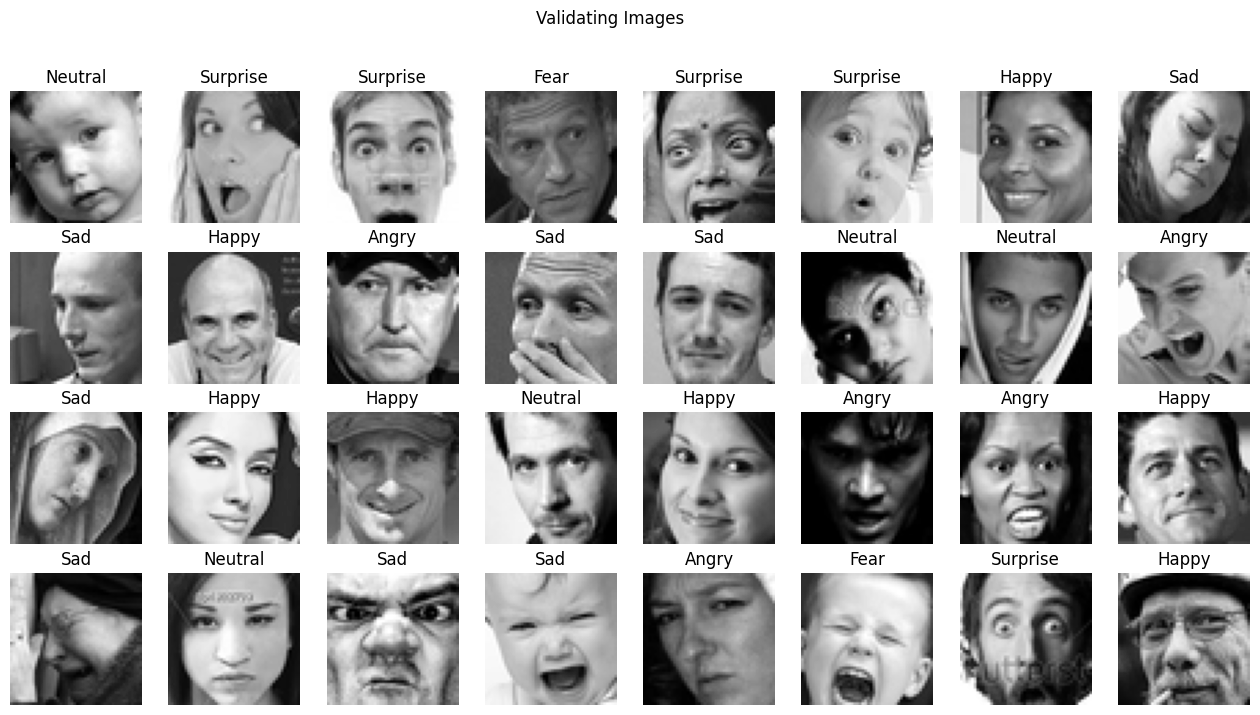

In [21]:
valid_idx = np.random.randint(low=0, high=len(x_valid), size=(32))
y_valid_labels = [decode_output(output, classes) for output in y_valid[valid_idx]]
plot_images(x_valid[valid_idx], y_valid_labels, title='Validating Images', 
            decode_labels=None, rows=4, cols=8, is_path=False,
            save_path=os.path.join(dataset_dir, 'validating_images.png'))

Number of images in the training dataset:	 28709
Number of images in the validation dataset:	  3589
Number of images in the testing dataset:	  3589
Image information: 48 x 48 x 1


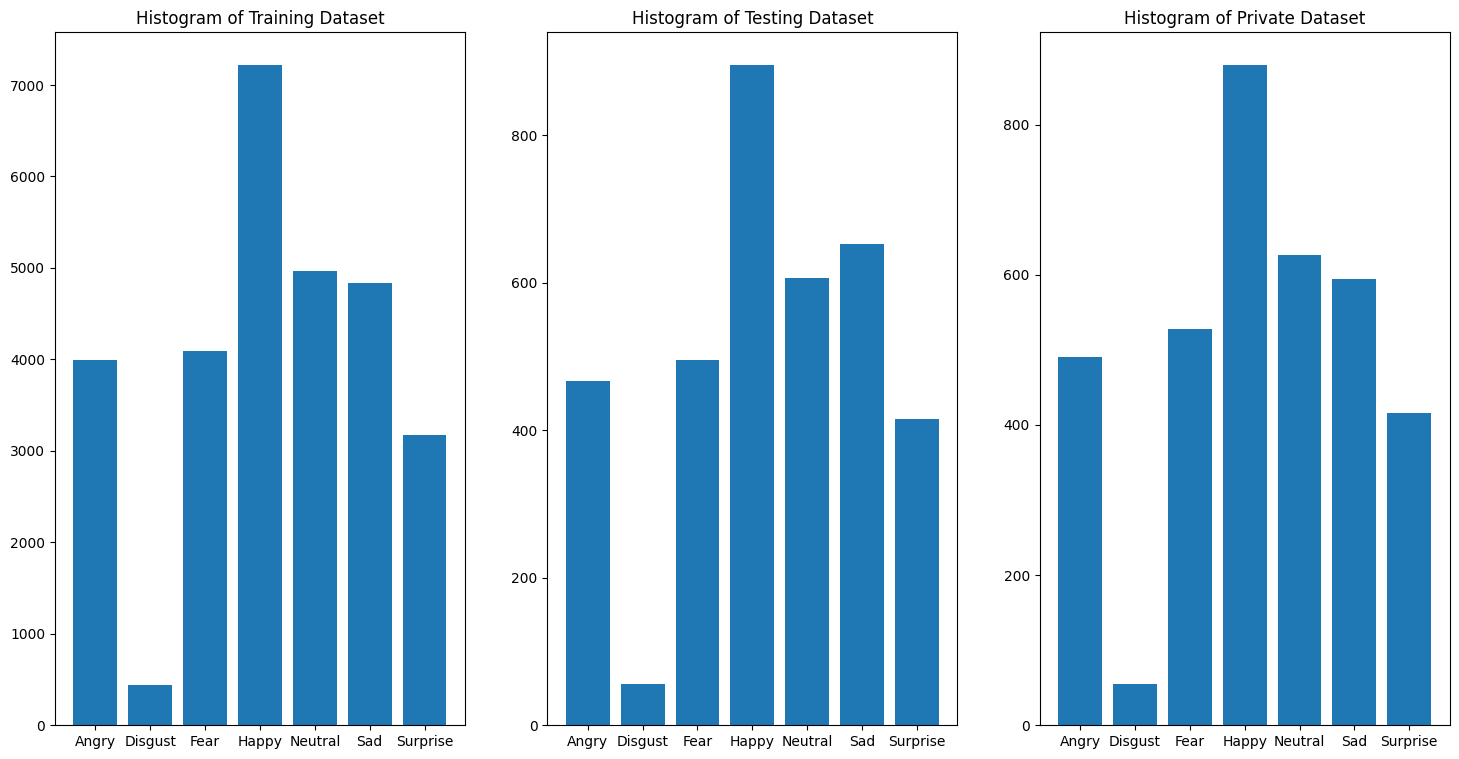

In [22]:
print("Number of images in the training dataset:\t{:>6}".format(len(train_files)))
print("Number of images in the validation dataset:\t{:>6}".format(len(public_files)))
print("Number of images in the testing dataset:\t{:>6}".format(len(private_files)))
print("Image information: %d x %d x %d"%(train_images[0].shape[0], train_images[0].shape[1], train_images[0].shape[2]))


plt.figure(figsize=(18,9))
plt.subplot(1,3,1), plotHist(train_labels,'Histogram of Training Dataset')
plt.subplot(1,3,2), plotHist(public_labels,'Histogram of Testing Dataset')
plt.subplot(1,3,3), plotHist(private_labels,'Histogram of Private Dataset')
save_figure(plt.gcf(), save_path=os.path.join(dataset_dir, 'histogram_data.png'))
plt.show()
plt.close()


## 4.Training

## 4.1 Configuration

In [23]:
classes_file = os.path.join(dataset_dir, 'classes.npy')
classes = np.load(classes_file)

def decode_output(output, classes):
    return classes[(np.argmax(output))]
  
print('Classes:', classes)

Classes: ['Angry' 'Disgust' 'Fear' 'Happy' 'Neutral' 'Sad' 'Surprise']


In [24]:
batch_size = 128
image_shape  = (48, 48, 1)
n_classes    = len(classes)

csv_logger_file_name = "fer2013_challenge_final_training_log.csv"
model_save_file_name = "fer2013_challenge_final_epoch-{epoch:02d}_val_loss-{val_loss:.2f}_val_acc-{val_accuracy:.2f}.h5"

# Call back Training
early_stop_patience  = 10

# Data Argument
zca_whitening                 = False
zca_epsilon                   = 1e-6
featurewise_center            = False
featurewise_std_normalization = False
rescale                       = None

In [25]:
training_runtime_id = "20180528_2100_03"
result_dir         = "results"

runtime_dir         = os.path.join(result_dir, training_runtime_id)
logs_dir            = os.path.join(runtime_dir, "logs")
checkpoints_dir     = os.path.join(runtime_dir, "checkpoints")
tensorboard_dir     = os.path.join(runtime_dir, "tensorboard")


print("runtime_dir:", runtime_dir)
print("logs_dir:", logs_dir)
print("checkpoints_dir:", checkpoints_dir)
print("tensorboard_dir:", tensorboard_dir)

if not os.path.exists(runtime_dir):
    os.makedirs(runtime_dir)
if not os.path.exists(logs_dir):
    os.makedirs(logs_dir)
if not os.path.exists(tensorboard_dir):
    os.makedirs(tensorboard_dir)
if not os.path.exists(checkpoints_dir):
    os.makedirs(checkpoints_dir)

runtime_dir: results/20180528_2100_03
logs_dir: results/20180528_2100_03/logs
checkpoints_dir: results/20180528_2100_03/checkpoints
tensorboard_dir: results/20180528_2100_03/tensorboard


In [26]:
training_runtime_description = "Training with Keras - final"
training_runtime_description_file = os.path.join(result_dir, training_runtime_id, 'description.txt')
!echo $training_runtime_description > $training_runtime_description_file
!head $training_runtime_description_file

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Training with Keras - final


## 4.2. Data Aguments

In [27]:
train_datagen = KerasImageDataGenerator(
                        # NEED TO FEED AND CAREFULLY (SAME WITH VALID), NEED TO FIT
                        # divide inputs by std of the dataset
                        featurewise_std_normalization = False, 
                        # apply ZCA whitening
                        zca_whitening      = zca_whitening, 
                        zca_epsilon        = zca_epsilon,       # epsilon for ZCA whitening   
                        featurewise_center = featurewise_center,# set input mean to 0 over the dataset
                        
                        # NEED TO FEED AND CAREFULLY (SAME WITH VALID)
                        rescale            = rescale, #  rescaling factor. If None or 0, no rescaling is applied, otherwise multiply the data by the value provided
    
                        samplewise_std_normalization = False, # divide each input by its std
    
                        # points outside the boundaries ('constant', 'nearest', 'reflect' or 'wrap'). 
                        # 'constant': kkkkkkkk|abcd|kkkkkkkk (cval=k) 
                        # 'nearest': aaaaaaaa|abcd|dddddddd 
                        # 'reflect': abcddcba|abcd|dcbaabcd 
                        # 'wrap': abcdabcd|abcd|abcdabcd
                        fill_mode          = 'nearest',
                        cval = 0, #value used for fill_mode 'constant'
                        
                        rotation_range     = 10.0, # degrees (0 to 180)
                        
                        width_shift_range = 0.1, # fraction of total width, if < 1, or pixels if >= 1.
                        height_shift_range= 0.1, # fraction of total height, if < 1, or pixels if >= 1.
                        shear_range       = 0.0, # shear intensity (shear angle in degrees).
                        zoom_range        = 0.1, # amount of zoom. if scalar z, zoom will be randomly picked in the range [1-z, 1+z]. A sequence of two can be passed instead to select this range.
                       
                        horizontal_flip   = True, # whether to randomly flip images horizontally
                        vertical_flip     = False  # whether to randomly flip images vertically
)
train_datagen.fit(train_images)

valid_datagen = KerasImageDataGenerator(
                        # NEED TO FEED AND CAREFULLY (SAME WITH VALID), NEED TO FIT
                        # divide inputs by std of the dataset
                        featurewise_std_normalization = False, 
                        # apply ZCA whitening
                        zca_whitening      = zca_whitening, 
                        zca_epsilon        = zca_epsilon, #  epsilon for ZCA whitening   
                        featurewise_center = featurewise_center, #  set input mean to 0 over the dataset
                        
                        # NEED TO FEED AND CAREFULLY (SAME WITH VALID)
                        rescale            = rescale, #  rescaling factor. If None or 0, no rescaling is applied, otherwise multiply the data by the value provided
);
valid_datagen.fit(train_images)

train_data_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size, shuffle=True)
valid_data_generator = valid_datagen.flow(x_valid, y_valid, batch_size=batch_size, shuffle=True)

## Summary

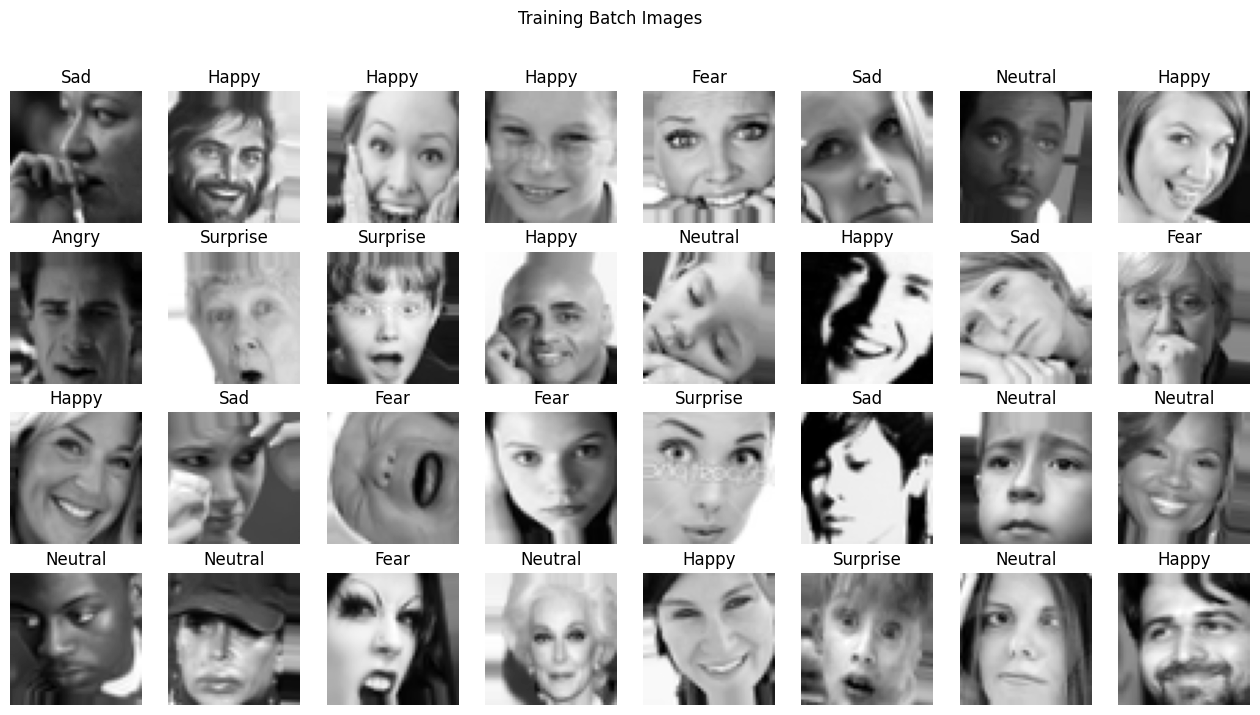

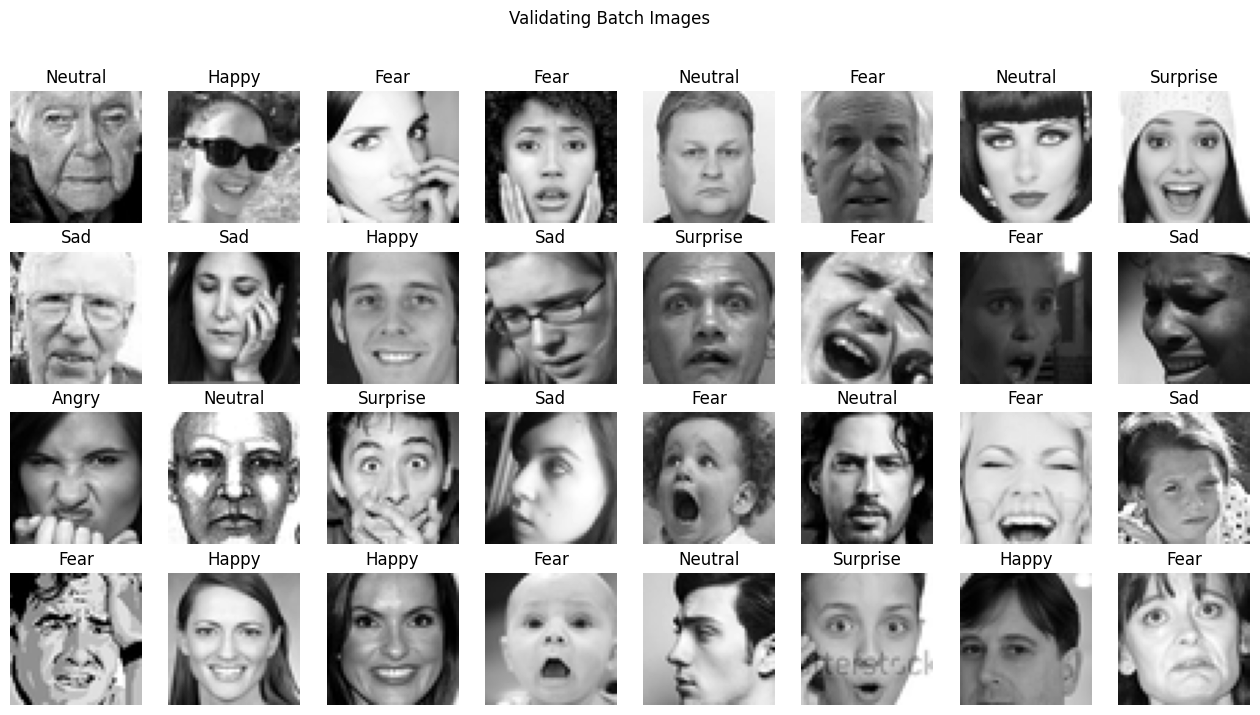

In [28]:
(train_image_batch, train_label_batch) = next(train_data_generator)
train_decode_label_batch = [decode_output(output, classes) for output in train_label_batch]
plot_images(train_image_batch, train_decode_label_batch, title='Training Batch Images', 
            decode_labels=None, data_dir=runtime_dir,
            rows=4, cols=8, is_path=False,
            save_path=os.path.join(runtime_dir, 'training_batch_images.png'))

(test_image_batch, test_label_batch) = next(valid_data_generator)
test_decode_label_batch = [decode_output(output, classes) for output in test_label_batch]
plot_images(test_image_batch, test_decode_label_batch, title='Validating Batch Images', 
            decode_labels=None, data_dir=runtime_dir,
            rows=4, cols=8, is_path=False,
            save_path=os.path.join(runtime_dir, 'validating_batch_images.png'))

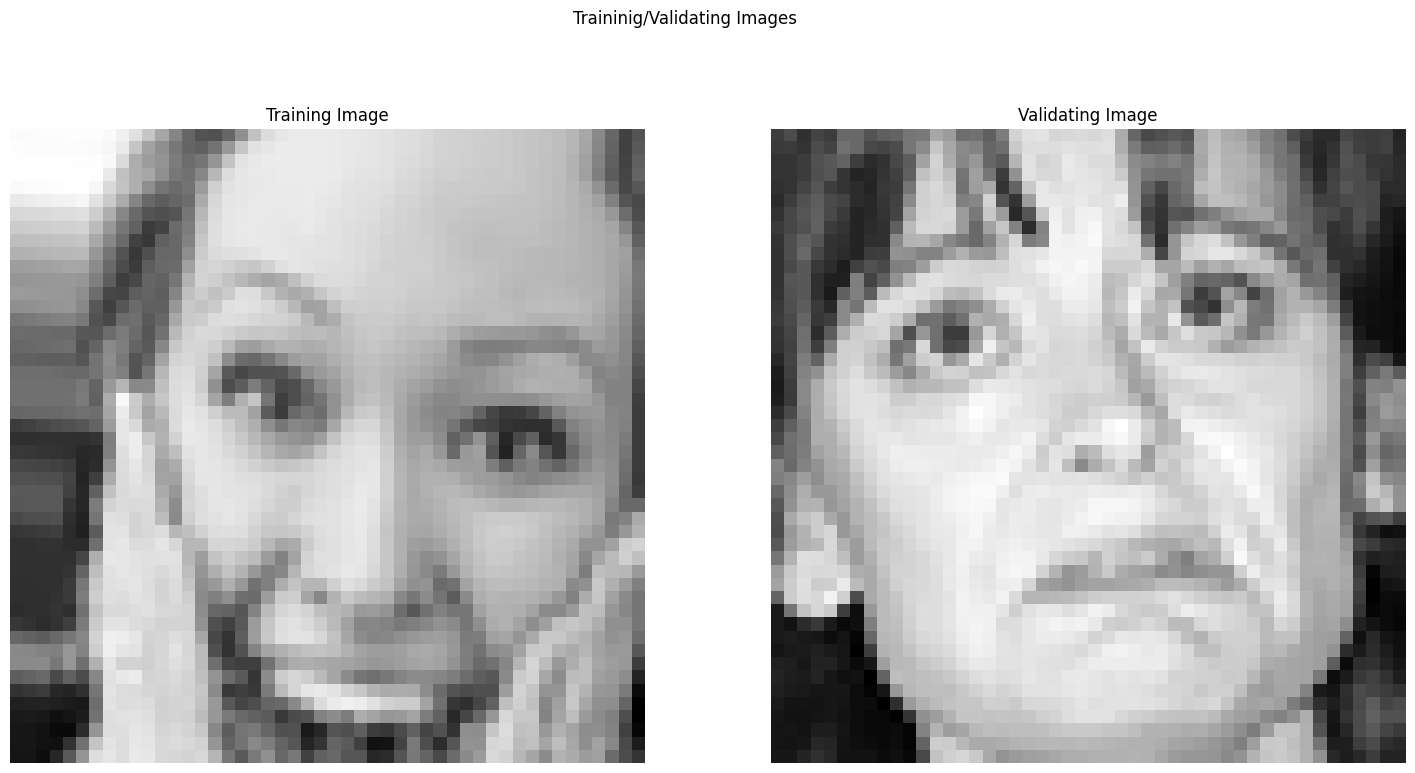

In [29]:
train_idx, valid_idx = (2, 31)
plt.figure(figsize=(18,9))
plt.subplot(1,2,1)
plt.title('Training Image')
plt.axis('off')
plt.imshow(train_image_batch[train_idx][:,:,0], cmap='gray')
plt.subplot(1,2,2)
plt.title('Validating Image')
plt.axis('off')
plt.imshow(test_image_batch[valid_idx][:,:,0], cmap='gray')
plt.suptitle('Traininig/Validating Images')
save_figure(plt.gcf(), save_path=os.path.join(runtime_dir, 'train_valid_images.png'))
plt.show()
plt.close()

Number of images in the training batch:	   128
Number of images in the validation batch:	   128
Image information: 48 x 48 x 1


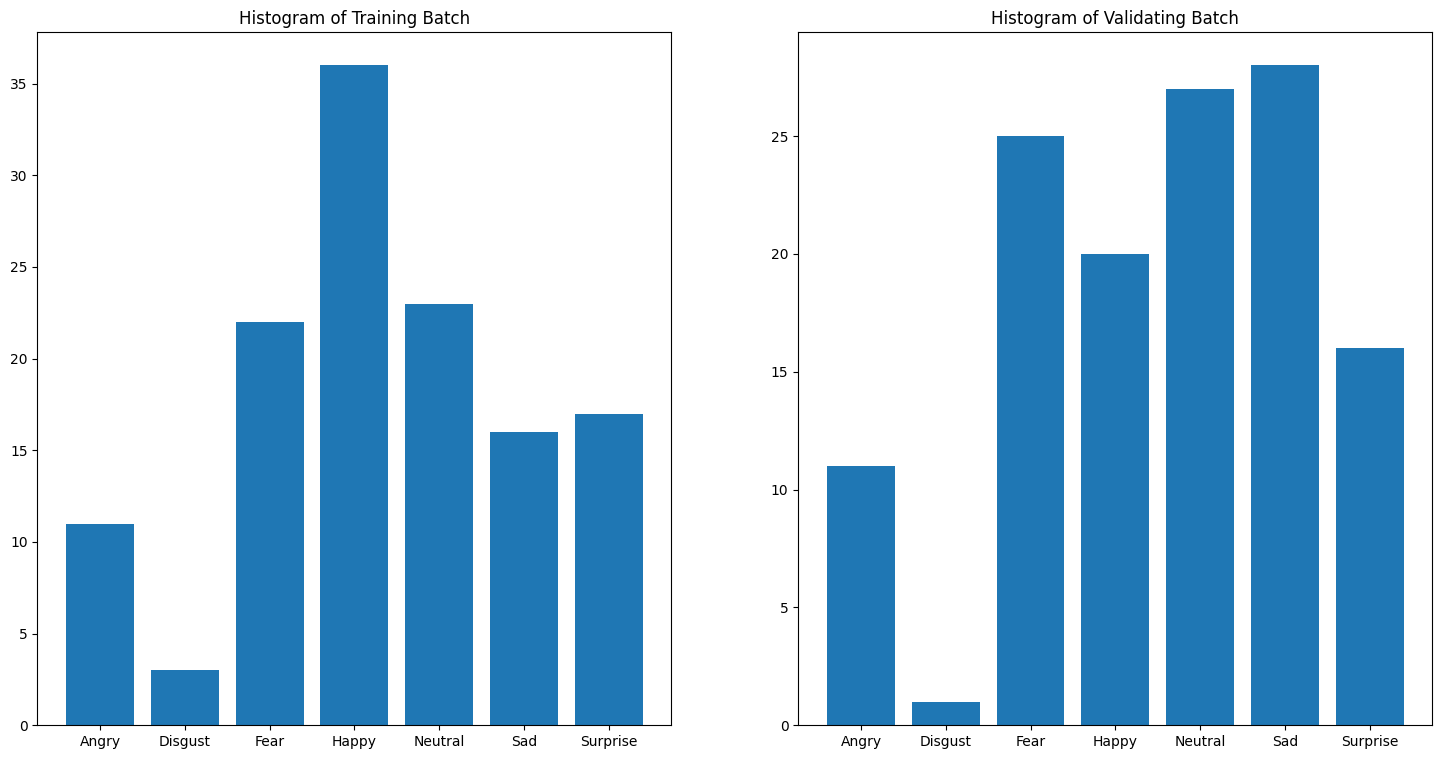

In [30]:
print("Number of images in the training batch:\t{:>6}".format(len(train_image_batch)))
print("Number of images in the validation batch:\t{:>6}".format(len(test_label_batch)))
print("Image information: %d x %d x %d"%(train_image_batch[0].shape[0], train_image_batch[0].shape[1], train_image_batch[0].shape[2]))


plt.figure(figsize=(18,9))
plt.subplot(1,2,1), plotHist(train_decode_label_batch,'Histogram of Training Batch')
plt.subplot(1,2,2), plotHist(test_decode_label_batch,'Histogram of Validating Batch')
save_figure(plt.gcf(), save_path=os.path.join(runtime_dir, 'histogram_image_batch.png'))
plt.show()
plt.close()

## 4.3 Build Model

In [31]:
import keras.backend as K

### TODO ###
weight_path = None # os.path.join(checkpoints_dir, 'fer2013_challenge_epoch-29_val_loss-1.18_val_acc-0.57.h5')

K.clear_session() # Clear previous models from memory.


# BUILD MODEL #
model = MEDIUM_CNN(n_classes, image_shape, weight_path)

# OPTIMIZE #
adam  = Adam(learning_rate=0.0001)
sgd = SGD(learning_rate=0.001, momentum=0.9, decay=0.0, nesterov=False)
# ada = Adadelta(lr=0.1, rho=0.95, epsilon=1e-08)


# COMPILE MODEL #
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


### Summary model

In [32]:

# serialize model to JSON
model_yaml = model.to_json()
with open(os.path.join(runtime_dir,"model.json"), "wt") as json_file:
    json_file.write(model_yaml)
          
description = model_summary_string(model)
f = open(os.path.join(runtime_dir, 'model.txt'), 'wt')
f.write(description)
f.close()

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_1 (Conv2D)                │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_3 (Conv2D)                │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_3 (Conv2D)                │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,327,303 (43.21 MB)

 Trainable params: 11,327,303 (43.21 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_1 (Conv2D)                │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_3 (Conv2D)                │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_3 (Conv2D)                │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,327,303 (43.21 MB)

 Trainable params: 11,327,303 (43.21 MB)

 Non-trainable params: 0 (0.00 B)

## 4.4. Callbacks

In [33]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # run GPU 0
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"  # run GPU 0,1
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   # don't run GPU
os.environ['KERAS_BACKEND'] = "tensorflow"

# CALLBACKS DURING TRAINING
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger, ReduceLROnPlateau, LambdaCallback
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, History

# ModelCheckpoint
model_save_dir = 'results/20180528_2100_01/checkpoints'
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
model_save_file_name = "fer2013_challenge_final_epoch-{epoch:02d}_val_loss-{val_loss:.2f}_val_acc-{val_accuracy:.2f}.keras"
model_save_path = os.path.join(model_save_dir, model_save_file_name)
model_checkpoint = ModelCheckpoint(filepath=model_save_path, 
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   save_freq='epoch')  # Save the model after every epoch

# CsvLogger Checkpoint
# Ensure the logs directory exists
logs_dir = 'results/20180528_2100_01/logs'
if not os.path.exists(logs_dir):
    os.makedirs(logs_dir)

# Set up the CSVLogger callback
csv_log_path = os.path.join(logs_dir, 'fer2013_challenge_final_training_log.csv')
csv_logger_checkpoint = CSVLogger(filename=csv_log_path, 
                                  separator=',', 
                                  append=True)

# EarlyStopping
early_stop_checkpoint = EarlyStopping(patience=10)

# TensorBoard
tensorboard_checkpoint = TensorBoard(log_dir='results/20180528_2100_01/tensorboard')

# Histogram Realtime Display
class HistogramCallback(Callback):
    def __init__(self, save_path=None):
        super(HistogramCallback, self).__init__()
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        if self.save_path:
            # Save histogram data here
            pass

histogram_checkpoint = HistogramCallback(save_path=os.path.join('results/20180528_2100_01/logs'))

# TerminateOnNaN
terminate_on_nan_checkpoint = TerminateOnNaN()

# LearningRateScheduler
# learning_rate_scheduler_checkpoint = LearningRateScheduler(schedule=lr_schedule)

# ReduceLROnPlateau
reduce_learning_rate_checkpoint = ReduceLROnPlateau(factor=0.1, cooldown=0, patience=2, min_lr=0.1e-6)

# Callbacks Registration
callbacks = [
    early_stop_checkpoint,         
    # terminate_on_nan_checkpoint,
    # learning_rate_scheduler_checkpoint,
    # reduce_learning_rate_checkpoint,
    # tensorboard_checkpoint, 
    histogram_checkpoint,
    csv_logger_checkpoint,
    model_checkpoint
]

## 4.5. Training

In [34]:
from math import ceil
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 0
final_epoch     = 120
steps_per_epoch = ceil(len(x_train) / batch_size)
val_dataset_size= len(x_valid)
validation_steps= ceil(val_dataset_size/batch_size)

In [35]:
  history = model.fit(
    x = train_data_generator,
    epochs = 120,
    validation_data = valid_data_generator,
    callbacks = callbacks
    )

Epoch 1/120


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734395255.435067     103 service.cc:145] XLA service 0x7bfc24003850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734395255.435157     103 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  4/225 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.1520 - loss: 7.3397

I0000 00:00:1734395265.408456     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2233 - loss: 2.3843
Epoch 1: val_loss improved from inf to 1.83554, saving model to results/20180528_2100_01/checkpoints/fer2013_challenge_final_epoch-01_val_loss-1.84_val_acc-0.25.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 33s 90ms/step - accuracy: 0.2235 - loss: 2.3804 - val_accuracy: 0.2516 - val_loss: 1.8355
Epoch 2/120
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2508 - loss: 1.8117
Epoch 2: val_loss improved from 1.83554 to 1.77705, saving model to results/20180528_2100_01/checkpoints/fer2013_challenge_final_epoch-02_val_loss-1.78_val_acc-0.30.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.2508 - loss: 1.8116 - val_accuracy: 0.3026 - val_loss: 1.7770
Epoch 3/120
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2838 - loss: 1.7643
Epoch 3: val_loss improved from 1.77705 to 1.61990, saving model to results/20180528_2100_01/checkpoints/fer2013_challenge_final_epoch-03_val_loss-1.62_val_acc-0.39.keras
2

## 4.6. Clean to retrain for Overfit

In [36]:
import csv

csv_log_path = os.path.join(logs_dir, csv_logger_file_name)
weights_dir = os.path.join(checkpoints_dir)
histogram_dir = os.path.join(logs_dir)

(final_log_history, final_weight_history, final_hist_history) = backup_after_train(csv_log_path, weights_dir, histogram_dir)

Epoch 44: val_loss=0.95, val_accuracy=0.66
Length of epoch: 45
Length of acc: 45
Length of val_acc: 45
Length of epoch: 45
Length of acc: 45
Length of val_acc: 45


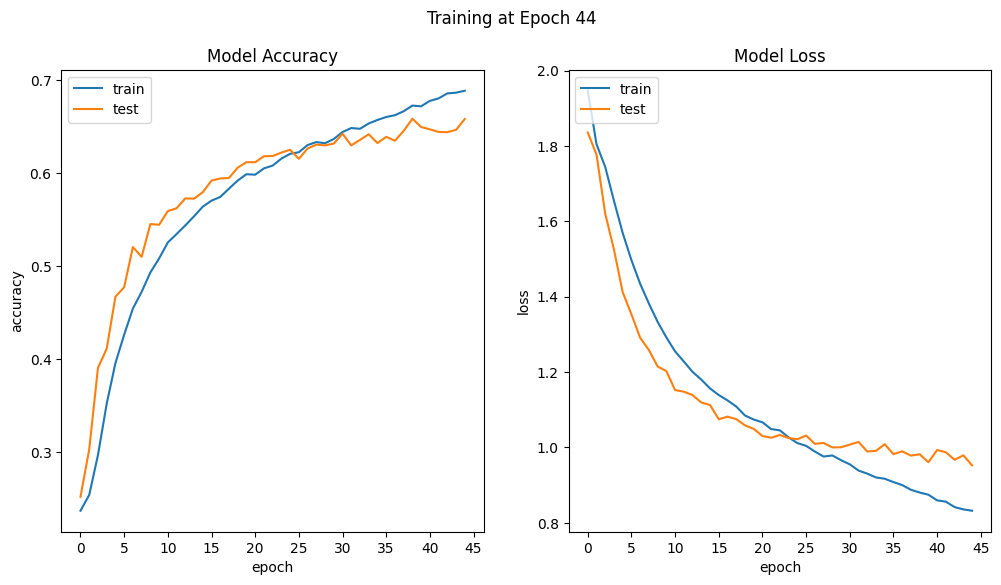

In [37]:
history = convert_history_dict(final_log_history)
print('Epoch %s: val_loss=%.2f, val_accuracy=%.2f'%(history['epoch'][-1],history['val_loss'][-1],history['val_accuracy'][-1]))
!ls $checkpoints_dir
show_history(history, save_path = os.path.join(runtime_dir, 'training_history.png'))

## 5.Evaluation

In [38]:
training_runtime_id = "20180528_2100_01"

runtime_dir         = os.path.join(result_dir, training_runtime_id)
logs_dir            = os.path.join(runtime_dir, "logs")
checkpoints_dir     = os.path.join(runtime_dir, "checkpoints")
tensorboard_dir     = os.path.join(runtime_dir, "tensorboard")

print('+ List of checkpoints:')
!ls $checkpoints_dir

+ List of checkpoints:
fer2013_challenge_final_epoch-01_val_loss-1.84_val_acc-0.25.keras
fer2013_challenge_final_epoch-02_val_loss-1.78_val_acc-0.30.keras
fer2013_challenge_final_epoch-03_val_loss-1.62_val_acc-0.39.keras
fer2013_challenge_final_epoch-04_val_loss-1.52_val_acc-0.41.keras
fer2013_challenge_final_epoch-05_val_loss-1.41_val_acc-0.47.keras
fer2013_challenge_final_epoch-06_val_loss-1.35_val_acc-0.48.keras
fer2013_challenge_final_epoch-07_val_loss-1.29_val_acc-0.52.keras
fer2013_challenge_final_epoch-08_val_loss-1.26_val_acc-0.51.keras
fer2013_challenge_final_epoch-09_val_loss-1.21_val_acc-0.55.keras
fer2013_challenge_final_epoch-10_val_loss-1.20_val_acc-0.54.keras
fer2013_challenge_final_epoch-11_val_loss-1.15_val_acc-0.56.keras
fer2013_challenge_final_epoch-12_val_loss-1.15_val_acc-0.56.keras
fer2013_challenge_final_epoch-13_val_loss-1.14_val_acc-0.57.keras
fer2013_challenge_final_epoch-14_val_loss-1.12_val_acc-0.57.keras
fer2013_challenge_final_epoch-15_val_loss-1.11_val_ac

In [46]:
evaluation_dir     = os.path.join(runtime_dir, "evaluation")
eval_weights_path  = os.path.join(checkpoints_dir, "fer2013_challenge_final_epoch-45_val_loss-0.95_val_acc-0.66.keras")

In [47]:
import os
if os.path.exists(evaluation_dir) == False:
    os.makedirs(evaluation_dir)

In [48]:
classes_file = os.path.join(dataset_dir, 'classes.npy')
classes = np.load(classes_file)

def decode_output(output, classes):
    return classes[(np.argmax(output))]

Number of images in the testing dataset:	  3589
Image information: 48 x 48 x 1


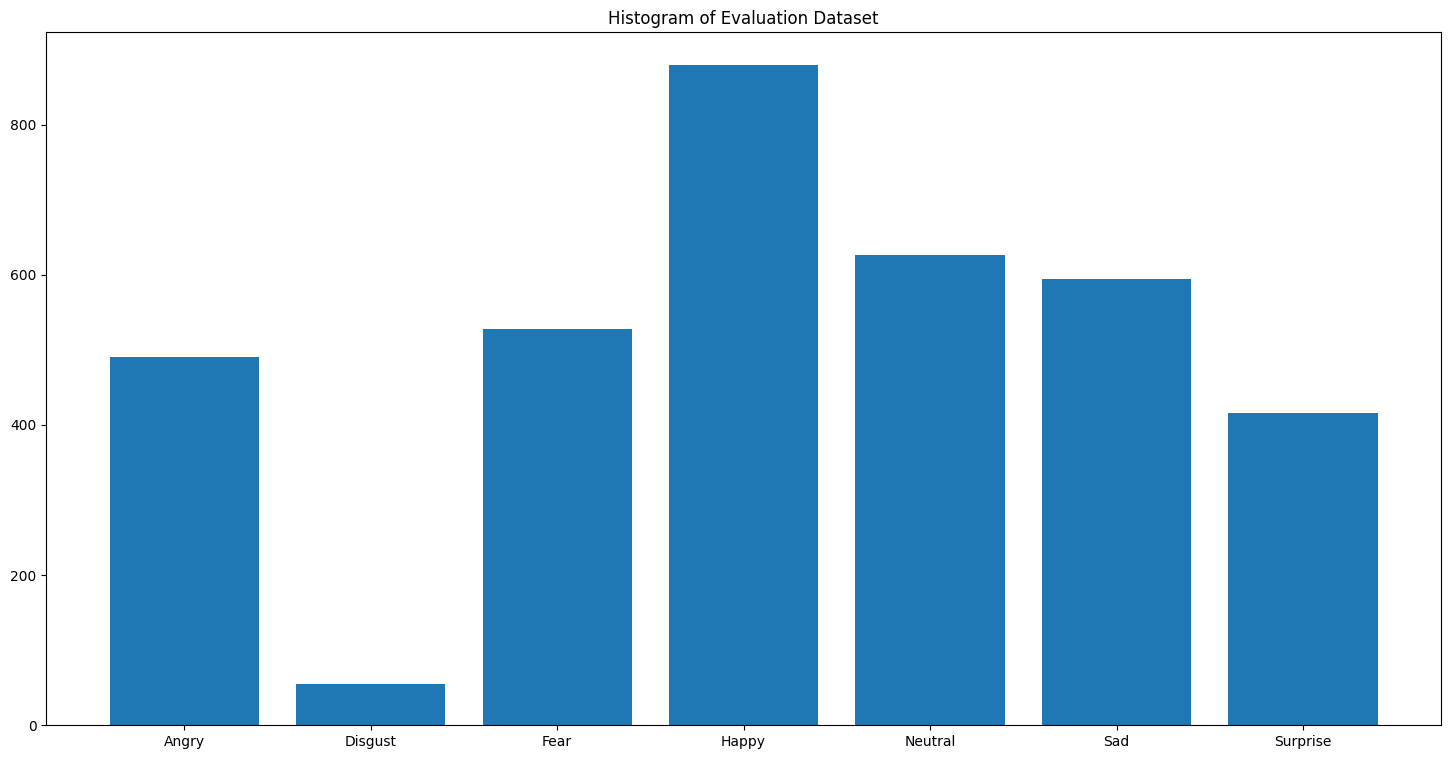

In [49]:
print("Number of images in the testing dataset:\t{:>6}".format(len(x_test)))
print("Image information: %d x %d x %d"%(x_test[0].shape[0], x_test[0].shape[1], x_test[0].shape[2]))

y_eval_labels = [decode_output(label, classes) for label in y_test]

plt.figure(figsize=(18,9))
plotHist(y_eval_labels,'Histogram of Evaluation Dataset')
save_figure(plt.gcf(), save_path=os.path.join(evaluation_dir, 'histogram_data_evaluation.png'))
plt.show()
plt.close()

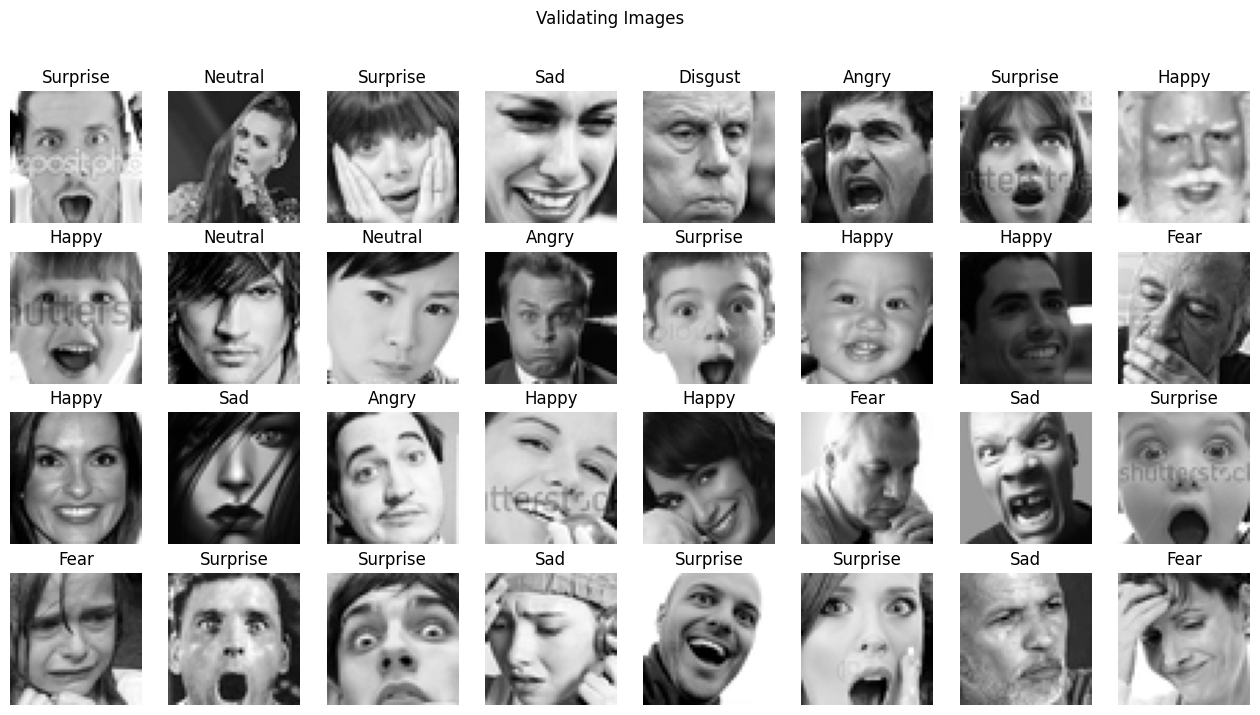

In [50]:
valid_idx = np.random.randint(low=0, high=len(x_valid), size=(32))
y_valid_labels  = [decode_output(output, classes) for output in y_valid[valid_idx]]
plot_images(x_valid[valid_idx], y_valid_labels, title='Validating Images', 
            decode_labels = None, data_dir = '',
            rows = 4, cols = 8, is_path = False,
            save_path = os.path.join(evaluation_dir, 'validating_images.png'))

In [51]:
test_datagen = KerasImageDataGenerator(
                        # NEED TO FEED AND CAREFULLY (SAME WITH VALID), NEED TO FIT
                        # divide inputs by std of the dataset
                        featurewise_std_normalization = False, 
                        # apply ZCA whitening
                        zca_whitening      = zca_whitening, 
                        zca_epsilon        = zca_epsilon, #  epsilon for ZCA whitening   
                        featurewise_center = featurewise_center, #  set input mean to 0 over the dataset
                        
                        # NEED TO FEED AND CAREFULLY (SAME WITH VALID)
                        rescale            = rescale, #  rescaling factor. If None or 0, no rescaling is applied, otherwise multiply the data by the value provided
);
test_datagen.fit(train_images)

test_data_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size, shuffle=False)

## 5.3. Load Model

In [52]:
from keras.models import load_model
eval_model = load_model(eval_weights_path)

In [53]:
eval_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_1 (Conv2D)                │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_3 (Conv2D)                │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_3 (Conv2D)                │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,981,911 (129.63 MB)

 Trainable params: 11,327,303 (43.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,654,608 (86.42 MB)

## 5.4. Evaluation

In [54]:
test_dataset_size= len(x_test)
test_steps= ceil(test_dataset_size/batch_size)

y_pred_test = eval_model.predict(x_test)
y_pred_test_labels = np.argmax(y_pred_test, axis=1)
y_test_labels = private_encoded_labels

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


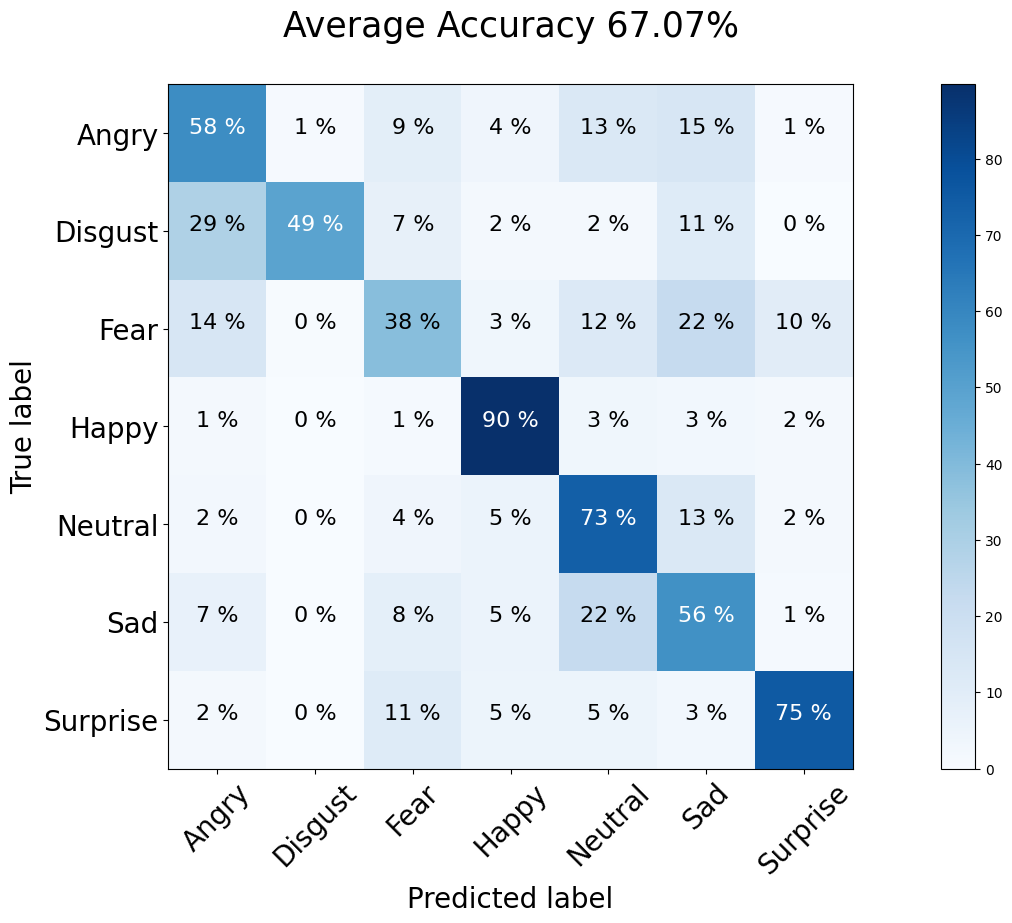

In [55]:
cm = confusion_matrix(y_test_labels, y_pred_test_labels)
precision = np.sum(np.diag(cm)) / np.sum(cm)
plot_confusion_matrix(y_test_labels, y_pred_test_labels, classes, title='Average Accuracy {:.2f}%\n'.format(precision*100.0))

In [56]:
mask_wrong = y_pred_test_labels != y_test_labels
x_wrong = x_test[mask_wrong]
y_wrong = y_test[mask_wrong]
y_wrong_pred_labels = y_pred_test_labels[mask_wrong]
y_wrong_true_labels = y_test_labels[mask_wrong]

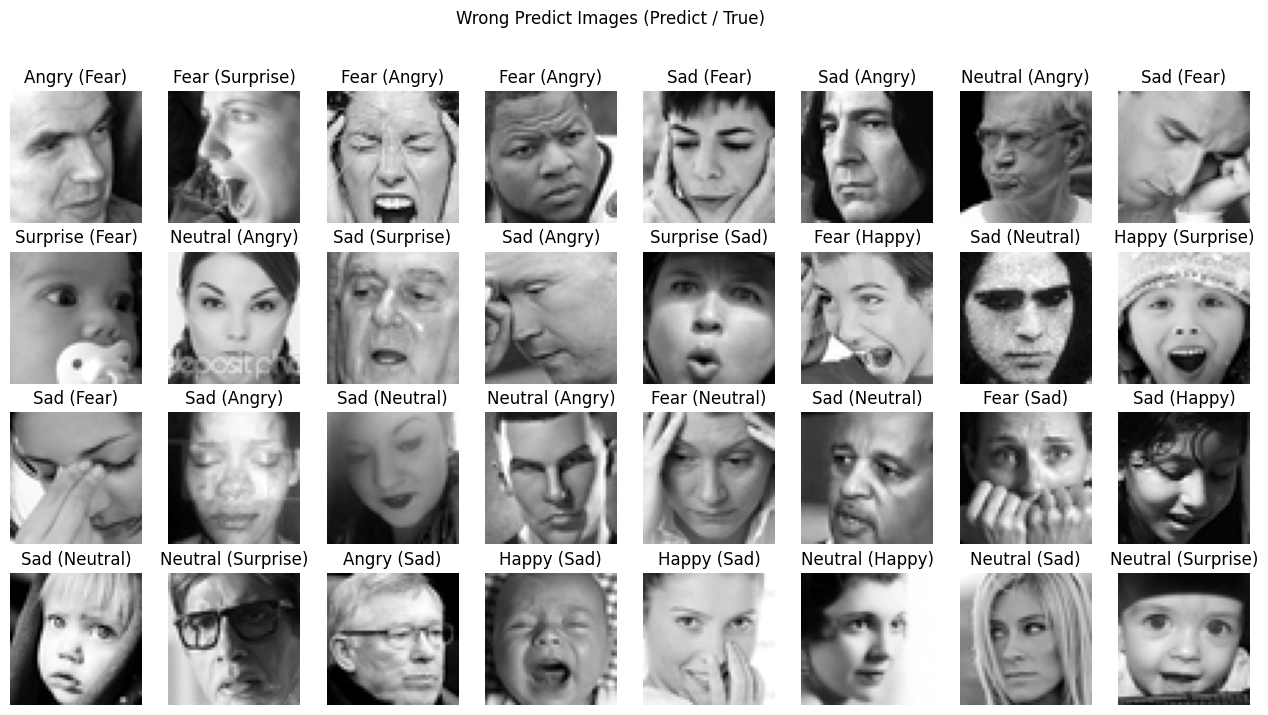

In [57]:
wrong_idx     = np.random.randint(low=0, high=len(x_wrong), size=(32))
wrong_titles  = ['%s (%s)'%(classes[y_wrong_pred_labels[wrong_idx[i]]], classes[y_wrong_true_labels[wrong_idx[i]]]) for i in range(len(wrong_idx))]
plot_images(x_wrong[wrong_idx], wrong_titles, title='Wrong Predict Images (Predict / True)', 
            decode_labels = None, data_dir = '',
            rows = 4, cols = 8, is_path = False,
            save_path = os.path.join(evaluation_dir, 'wrong_predict_images.png'))

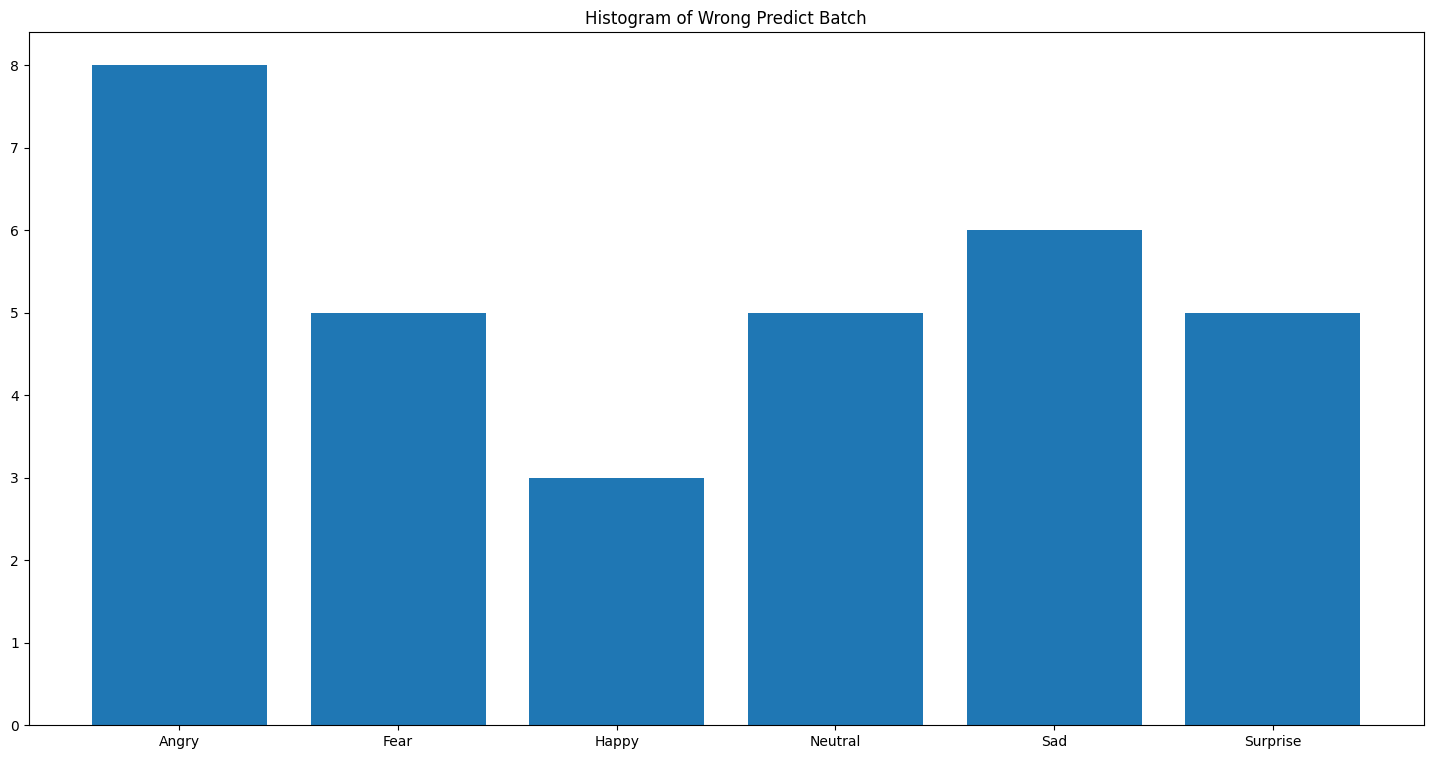

In [58]:
plt.figure(figsize=(18,9))
plotHist(classes[y_wrong_true_labels[wrong_idx]],'Histogram of Wrong Predict Batch')
save_figure(plt.gcf(), save_path=os.path.join(evaluation_dir, 'histogram_wrong_case_evaluation.png'))
plt.show()
plt.close()

## 5.6. True Cases

In [59]:
mask_true = y_pred_test_labels == y_test_labels
x_true = x_test[mask_true]
y_true = y_test[mask_true]
y_true_pred_labels = y_pred_test_labels[mask_true]
y_true_true_labels = y_test_labels[mask_true]

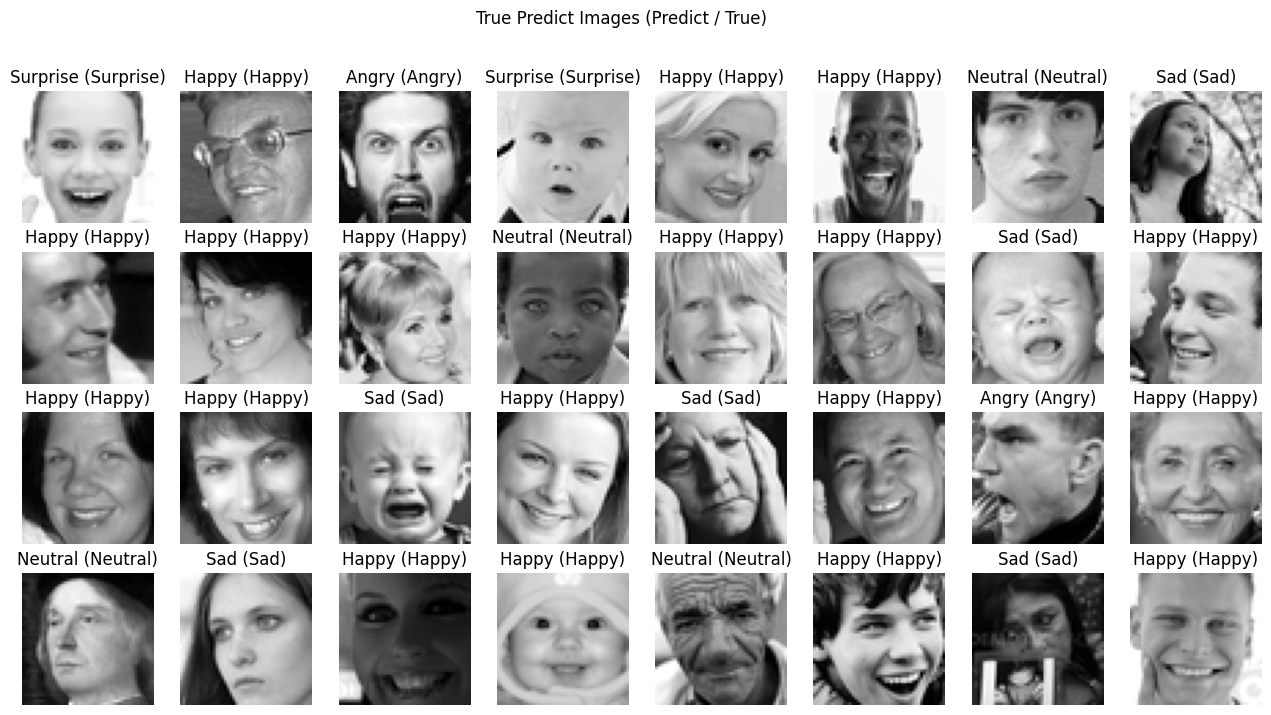

In [60]:
true_idx     = np.random.randint(low=0, high=len(x_true), size=(32))
true_titles  = ['%s (%s)'%(classes[y_true_pred_labels[true_idx[i]]], classes[y_true_true_labels[true_idx[i]]]) for i in range(len(true_idx))]
plot_images(x_true[true_idx], true_titles, title='True Predict Images (Predict / True)', 
            decode_labels = None, data_dir = '',
            rows = 4, cols = 8, is_path = False,
            save_path = os.path.join(evaluation_dir, 'true_predict_images.png'))

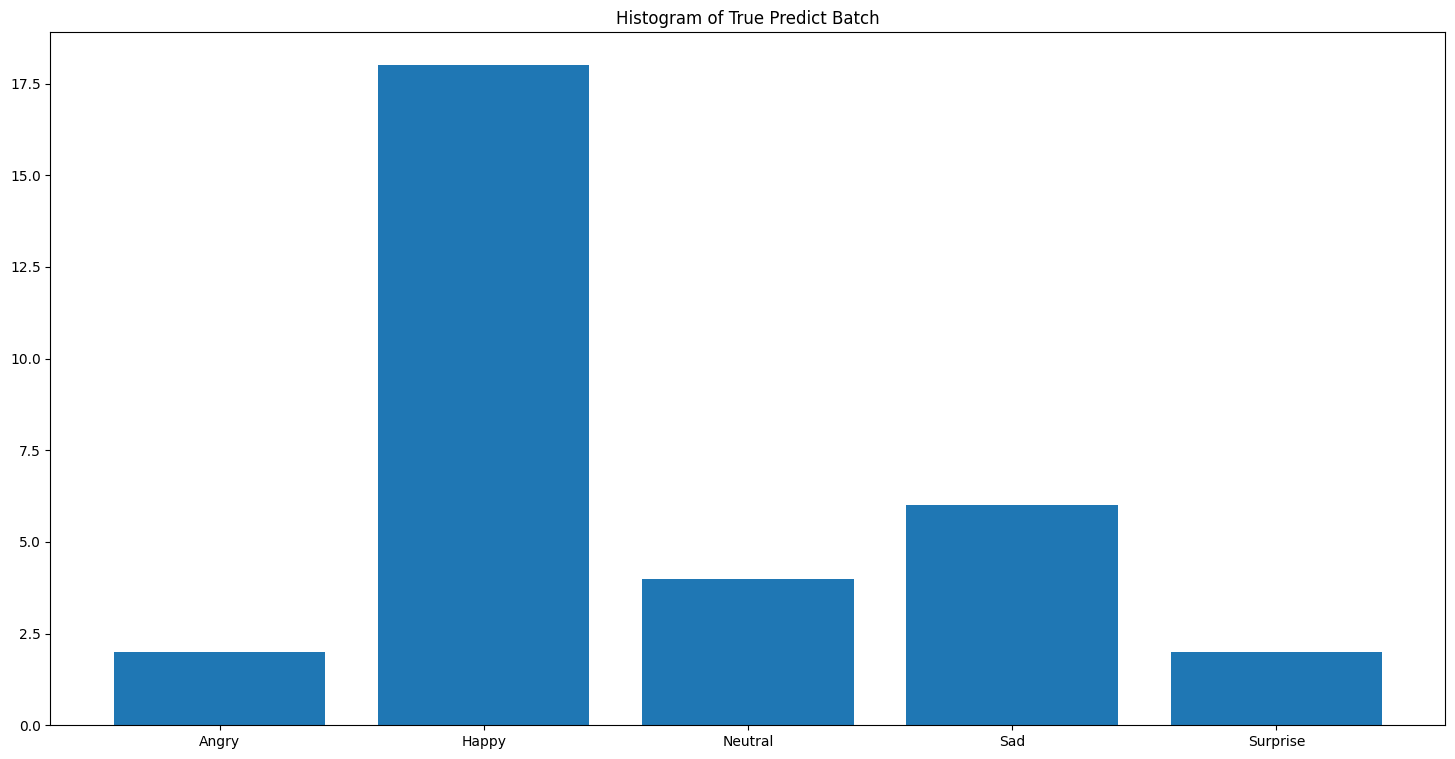

In [61]:
plt.figure(figsize=(18,9))
plotHist(classes[y_true_true_labels[true_idx]],'Histogram of True Predict Batch')
save_figure(plt.gcf(), save_path=os.path.join(evaluation_dir, 'histogram_true_case_evaluation.png'))
plt.show()
plt.close()

# End